In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tensorflow import keras
from tensorflow.keras import layers
from sklearn import metrics

In [6]:
tsla_df = pd.read_csv("./docs/Homework3 - TSLA.csv")
tesla_data = tsla_df
tesla_data['Date'] = pd.to_datetime(tesla_data['Date'])
tesla_data.set_index('Date', inplace=True)
tesla_data.sort_index(inplace=True)
tesla_data = tesla_data[:2950]

# Split data into training and testing sets (70% train, 30% test)
train_size = int(len(tesla_data) * 0.7)
train_data = tesla_data[:train_size]
test_data = tesla_data[train_size:]

train_data = train_data["Close"].tolist()
test_data = test_data["Close"].tolist()

In [7]:
def to_sequences(obs, SEQUENCE_SIZE):
    x = []
    y = []

    for i in range(len(obs) - SEQUENCE_SIZE):
        #print(i)
        window = obs[i:(i + SEQUENCE_SIZE)]
        after_window = obs[i + SEQUENCE_SIZE]
        window = [[x] for x in window]
        #print("{} - {}".format(window,after_window))
        x.append(window)
        y.append(after_window)

    return np.array(x), np.array(y)

# Create sequences for LSTM
def create_sequences(data, seq_length):
    sequences = []
    labels = []
    for i in range(len(data) - seq_length):
        sequences.append(data[i:i + seq_length])
        labels.append(data[i + seq_length])
    return np.array(sequences), np.array(labels)

SEQUENCE_SIZE = 10
x_train, y_train = to_sequences(train_data, SEQUENCE_SIZE)
x_test, y_test = to_sequences(test_data, SEQUENCE_SIZE)

print("Shape of training set: {}".format(x_train.shape))
print("Shape of test set: {}".format(x_test.shape))

Shape of training set: (2055, 10, 1)
Shape of test set: (875, 10, 1)


In [8]:
def transformer_encoder(inputs, head_size, num_heads, ff_dim, dropout=0):
    # Normalization and Attention
    x = layers.LayerNormalization(epsilon=1e-6)(inputs)
    x = layers.MultiHeadAttention(
        key_dim=head_size, num_heads=num_heads, dropout=dropout
    )(x, x)
    x = layers.Dropout(dropout)(x)
    res = x + inputs

    # Feed Forward Part
    x = layers.LayerNormalization(epsilon=1e-6)(res)
    x = layers.Conv1D(filters=ff_dim, kernel_size=1, activation="relu")(x)
    x = layers.Dropout(dropout)(x)
    x = layers.Conv1D(filters=inputs.shape[-1], kernel_size=1)(x)
    return x + res

In [9]:
def build_model(
        input_shape,
        head_size,
        num_heads,
        ff_dim,
        num_transformer_blocks,
        mlp_units,
        dropout=0,
        mlp_dropout=0,
):
    inputs = keras.Input(shape=input_shape)
    x = inputs
    for _ in range(num_transformer_blocks):
        x = transformer_encoder(x, head_size, num_heads, ff_dim, dropout)

    x = layers.GlobalAveragePooling1D(data_format="channels_first")(x)
    for dim in mlp_units:
        x = layers.Dense(dim, activation="relu")(x)
        x = layers.Dropout(mlp_dropout)(x)
    outputs = layers.Dense(1)(x)
    return keras.Model(inputs, outputs)

In [10]:
input_shape = x_train.shape[1:]

model = build_model(
    input_shape,
    head_size=256,
    num_heads=4,
    ff_dim=4,
    num_transformer_blocks=4,
    mlp_units=[128],
    mlp_dropout=0.4,
    dropout=0.25,
)

model.compile(
    loss="mean_squared_error",
    optimizer=keras.optimizers.Adam(learning_rate=1e-4)
)

callbacks = [keras.callbacks.EarlyStopping(patience=10,
                                           restore_best_weights=True)]

model.fit(
    x_train,
    y_train,
    validation_split=0.2,
    epochs=5,
    batch_size=64,
    callbacks=callbacks,
)


Epoch 1/5
26/26 ━━━━━━━━━━━━━━━━━━━━ 7s 38ms/step - loss: 337.2578 - val_loss: 272.2637
Epoch 2/5
26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - loss: 193.7557 - val_loss: 56.4877
Epoch 3/5
26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - loss: 165.7170 - val_loss: 21.2636
Epoch 4/5
26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - loss: 157.9677 - val_loss: 19.5067
Epoch 5/5
26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - loss: 131.9351 - val_loss: 22.9917


In [12]:
model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 10, 1)     │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalization │ (None, 10, 1)     │          2 │ input_layer[0][0] │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multi_head_attenti… │ (None, 10, 1)     │      7,169 │ layer_normalizat… │
│ (MultiHeadAttentio… │                   │            │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_1 (Dropout) │ (None, 10, 1)     │          0 │ multi_head_atten… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add (Add)           │ (None, 10, 1)     │          0 │ dropout_1[0][0],  │
│                     │                   │            │ input_layer[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 10, 1)     │          2 │ add[0][0]         │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d (Conv1D)     │ (None, 10, 4)     │          8 │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_2 (Dropout) │ (None, 10, 4)     │          0 │ conv1d[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_1 (Conv1D)   │ (None, 10, 1)     │          5 │ dropout_2[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_1 (Add)         │ (None, 10, 1)     │          0 │ conv1d_1[0][0],   │
│                     │                   │            │ add[0][0]         │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 10, 1)     │          2 │ add_1[0][0]       │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multi_head_attenti… │ (None, 10, 1)     │      7,169 │ layer_normalizat… │
│ (MultiHeadAttentio… │                   │            │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_4 (Dropout) │ (None, 10, 1)     │          0 │ multi_head_atten… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_2 (Add)         │ (None, 10, 1)     │          0 │ dropout_4[0][0],  │
│                     │                   │            │ add_1[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 10, 1)     │          2 │ add_2[0][0]       │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_2 (Conv1D)   │ (None, 10, 4)     │          8 │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_5 (Dropout) │ (None, 10, 4)     │          0 │ conv1d_2[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_3 (Conv1D)   │ (None, 10, 1)     │          5 │ dropout_5[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_3 (Add)         │ (None, 10, 1)     │          0 │ conv1d_3[0][0],   │
│                     │                   │            │ add_2[0][0]       │
├─────────────────────┼───────────────────┼────────────┼─────────────────

 Total params: 90,845 (354.87 KB)

 Trainable params: 30,281 (118.29 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 60,564 (236.58 KB)

In [13]:
pred = model.predict(x_test)
score = np.sqrt(metrics.mean_squared_error(pred, y_test))
print("Score (RMSE): {}".format(score))

28/28 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step
Score (RMSE): 45.90919745219089


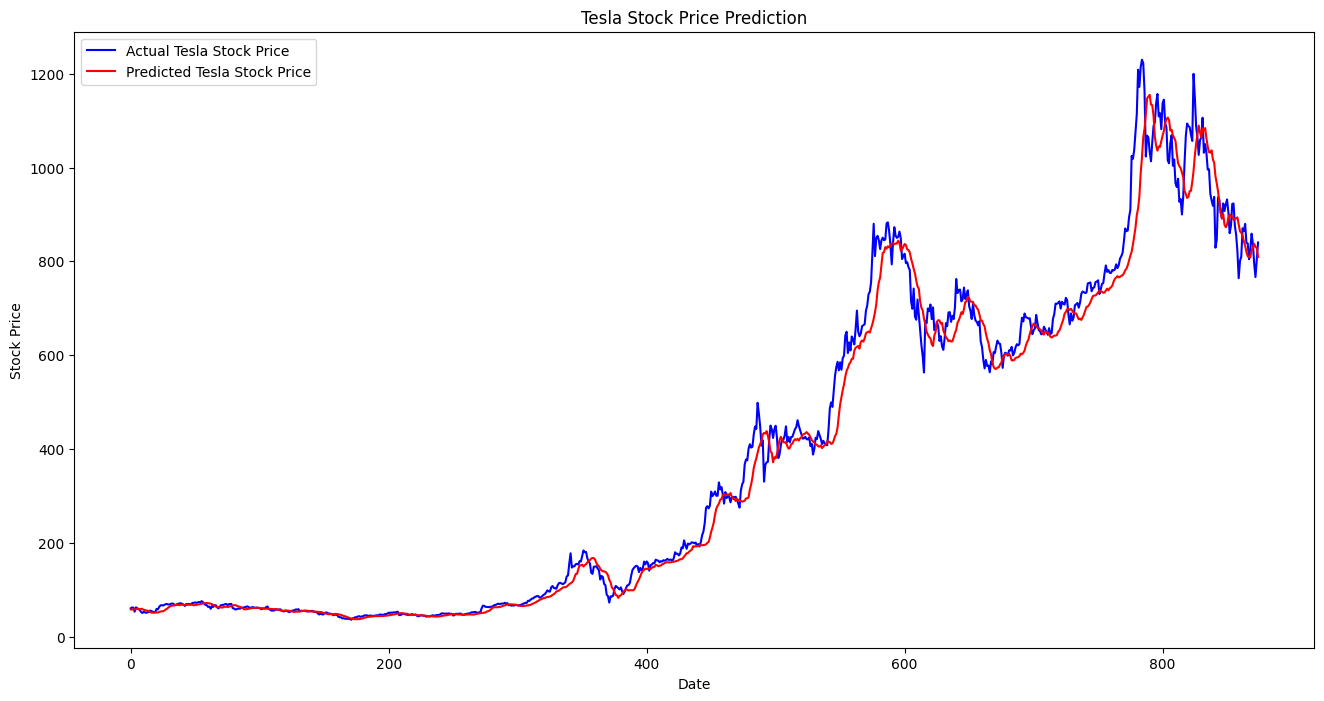

In [14]:
# Plot the results
plt.figure(figsize=(16, 8))
plt.plot(y_test, color='blue', label='Actual Tesla Stock Price')
plt.plot(pred, color='red', label='Predicted Tesla Stock Price')
plt.title('Tesla Stock Price Prediction')
plt.xlabel('Date')
plt.ylabel('Stock Price')
plt.legend()
plt.show()

In [15]:
# Load gold price data
gold_data = pd.read_csv('./docs/gold.csv')
gold_data.sort_values('Date', inplace=True)
gold_data['Date'] = pd.to_datetime(gold_data['Date'])

In [16]:
combined = pd.merge(tesla_data, gold_data, on='Date', how='inner')
combined_data = np.array(combined[[ 'Close_x', 'Close_y']])
# combined_data = combined[['Close_x', 'Close_y']]

In [18]:
# Prepare the dataset for LSTM
def create_dataset_with_gold(dataset, time_step=1):
    X, Y = [], []
    for i in range(len(dataset) - time_step - 1):
        a = dataset[i:(i + time_step), :]  # Use 'Close' and 'Gold' prices
        X.append(a)
        Y.append(dataset[i + time_step, :])  # Predict both 'Close_x' and 'Close_y'
    return np.array(X), np.array(Y)

In [19]:
X, Y = create_dataset_with_gold(combined_data, SEQUENCE_SIZE)

In [20]:
print("Shape of training set: {}".format(X.shape))
print("Shape of test set: {}".format(Y.shape))

Shape of training set: (2867, 10, 2)
Shape of test set: (2867, 2)


In [21]:
# Split the data into training and testing sets (70% training, 30% testing)
train_size = int(len(X) * 0.7)
x_train, x_test = X[:train_size], X[train_size:]
y_train, y_test = Y[:train_size], Y[train_size:]

In [22]:
print("Shape of training set: {}".format(x_train.shape))
print("Shape of test set: {}".format(x_test.shape))

Shape of training set: (2006, 10, 2)
Shape of test set: (861, 10, 2)


In [23]:
def transformer_encoder_with_gold(inputs, head_size, num_heads, ff_dim, dropout=0):
    # Normalization and Attention
    x = layers.LayerNormalization(epsilon=1e-6)(inputs)
    x = layers.MultiHeadAttention(
        key_dim=head_size, num_heads=num_heads, dropout=dropout
    )(x, x)
    x = layers.Dropout(dropout)(x)
    res = x + inputs

    # Feed Forward Part
    x = layers.LayerNormalization(epsilon=1e-6)(res)
    x = layers.Conv1D(filters=ff_dim, kernel_size=1, activation="relu")(x)
    x = layers.Dropout(dropout)(x)
    x = layers.Conv1D(filters=inputs.shape[-1], kernel_size=1)(x)
    return x + res

In [24]:
def build_model_with_gold(
        input_shape,
        head_size,
        num_heads,
        ff_dim,
        num_transformer_blocks,
        mlp_units,
        dropout=0,
        mlp_dropout=0,
):
    inputs = keras.Input(shape=input_shape)
    x = inputs
    for _ in range(num_transformer_blocks):
        x = transformer_encoder_with_gold(x, head_size, num_heads, ff_dim, dropout)

    x = layers.GlobalAveragePooling1D()(x)
    for dim in mlp_units:
        x = layers.Dense(dim, activation="relu")(x)
        x = layers.Dropout(mlp_dropout)(x)
    
    # Added the first Dense layer
    x = layers.Dense(128, activation="relu")(x)  # Added this line
    x = layers.Dropout(mlp_dropout)(x)           # Added this line
    
    outputs = layers.Dense(2)(x)
    return keras.Model(inputs, outputs)

In [33]:
input_shape = x_train.shape[1:]

model_with_gold = build_model_with_gold(
    input_shape,
    head_size=256,
    num_heads=4,
    ff_dim=4,
    num_transformer_blocks=4,
    mlp_units=[128],
    mlp_dropout=0.4,
    dropout=0.25,
)

model_with_gold.compile(
    loss="mean_squared_error",
    optimizer=keras.optimizers.Adam(learning_rate=1e-4)
)

callbacks = [keras.callbacks.EarlyStopping(patience=10,
                                           restore_best_weights=True)]

model_with_gold.fit(
    x_train,
    y_train,
    validation_split=0.2,
    epochs=10,
    batch_size=64,
    callbacks=callbacks,
)


Epoch 1/10
26/26 ━━━━━━━━━━━━━━━━━━━━ 7s 38ms/step - loss: 930829.7500 - val_loss: 563852.4375
Epoch 2/10
26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - loss: 686108.6875 - val_loss: 384858.5625
Epoch 3/10
26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - loss: 482629.6562 - val_loss: 246006.0312
Epoch 4/10
26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - loss: 331971.8125 - val_loss: 141986.2344
Epoch 5/10
26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - loss: 210320.7031 - val_loss: 68113.1953
Epoch 6/10
26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - loss: 149175.1875 - val_loss: 25810.5039
Epoch 7/10
26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - loss: 102239.1250 - val_loss: 8246.1709
Epoch 8/10
26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - loss: 83762.9297 - val_loss: 2405.7520
Epoch 9/10
26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - loss: 77056.1562 - val_loss: 1351.5201
Epoch 10/10
26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - loss: 70657.2266 - val_loss: 886.0244


In [34]:
model_with_gold.summary()

Model: "functional_7"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_3       │ (None, 10, 2)     │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 10, 2)     │          4 │ input_layer_3[0]… │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multi_head_attenti… │ (None, 10, 2)     │     11,266 │ layer_normalizat… │
│ (MultiHeadAttentio… │                   │            │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_42          │ (None, 10, 2)     │          0 │ multi_head_atten… │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_24 (Add)        │ (None, 10, 2)     │          0 │ dropout_42[0][0], │
│                     │                   │            │ input_layer_3[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 10, 2)     │          4 │ add_24[0][0]      │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_24 (Conv1D)  │ (None, 10, 4)     │         12 │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_43          │ (None, 10, 4)     │          0 │ conv1d_24[0][0]   │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_25 (Conv1D)  │ (None, 10, 2)     │         10 │ dropout_43[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_25 (Add)        │ (None, 10, 2)     │          0 │ conv1d_25[0][0],  │
│                     │                   │            │ add_24[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 10, 2)     │          4 │ add_25[0][0]      │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multi_head_attenti… │ (None, 10, 2)     │     11,266 │ layer_normalizat… │
│ (MultiHeadAttentio… │                   │            │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_45          │ (None, 10, 2)     │          0 │ multi_head_atten… │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_26 (Add)        │ (None, 10, 2)     │          0 │ dropout_45[0][0], │
│                     │                   │            │ add_25[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 10, 2)     │          4 │ add_26[0][0]      │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_26 (Conv1D)  │ (None, 10, 4)     │         12 │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_46          │ (None, 10, 4)     │          0 │ conv1d_26[0][0]   │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_27 (Conv1D)  │ (None, 10, 2)     │         10 │ dropout_46[0][0]

 Total params: 187,016 (730.54 KB)

 Trainable params: 62,338 (243.51 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 124,678 (487.03 KB)

In [35]:
pred = model_with_gold.predict(x_test)
score = np.sqrt(metrics.mean_squared_error(y_test, pred))
print("Score (RMSE): {}".format(score))

27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step
Score (RMSE): 311.8437740503172


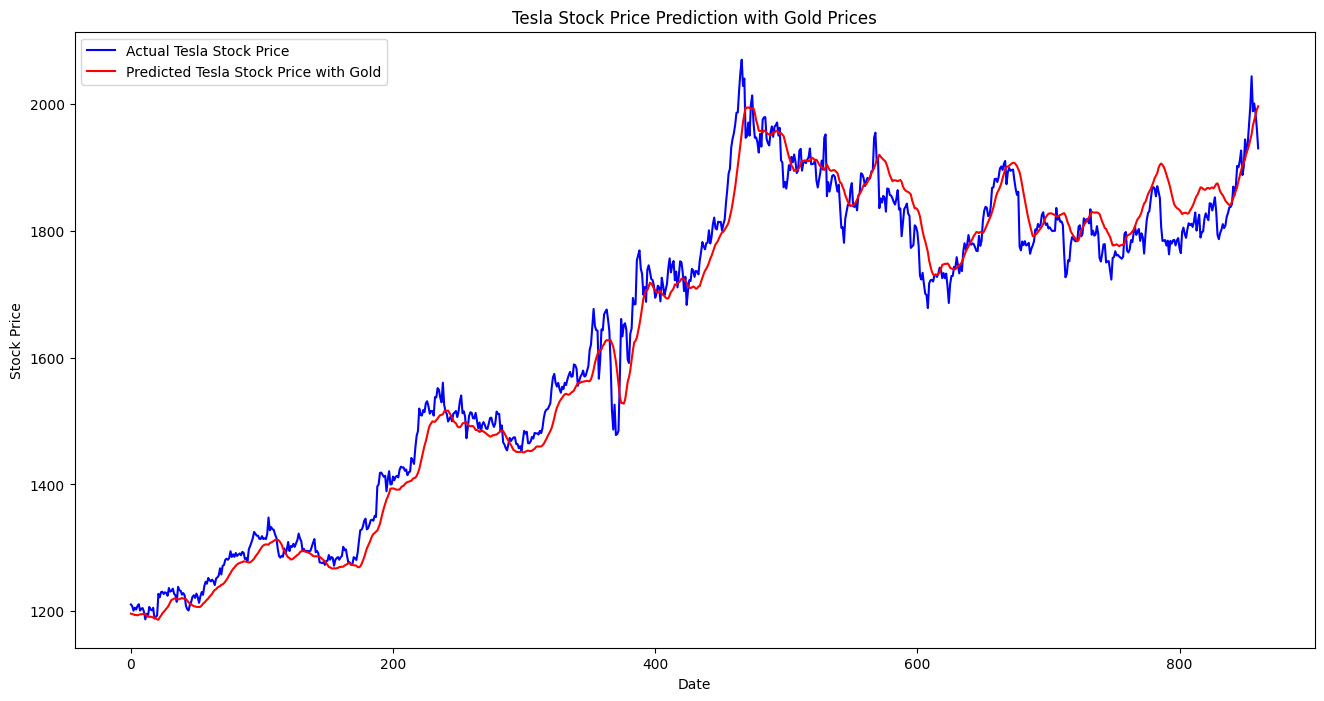

In [36]:
# Plot the results
plt.figure(figsize=(16, 8))
plt.plot(y_test[:,1], color='blue', label='Actual Tesla Stock Price')
plt.plot(pred[:,1], color='red', label='Predicted Tesla Stock Price with Gold')
plt.title('Tesla Stock Price Prediction with Gold Prices')
plt.xlabel('Date')
plt.ylabel('Stock Price')
plt.legend()
plt.show()